In [38]:
import warnings

import numpy as np
import rasterio
import geopandas as gpd
import pandas as pd
from shapely.geometry import *
from shapely.errors import ShapelyDeprecationWarning
import shapely.affinity
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from mpl_toolkits.axes_grid1 import make_axes_locatable
plt.rcParams["figure.facecolor"] = "white"
plt.rcParams["axes.facecolor"] = "white"
plt.rcParams["font.family"] = "Arial"

from scrollstats import BendDataset, calculate_ridge_metrics, RASTER_PATHS

In [39]:
def join_packet_info(itx, packets):

    itx_packets = itx.copy()

    itx_packets = itx_packets.sjoin(packets.drop("bend_id", axis=1))
    itx_packets = itx_packets.reset_index().set_index(["packet_id", "transect_id", "ridge_id"])

    return itx_packets

In [40]:
def calc_component_geometries(in_gdf):

    gdf = in_gdf.copy()

    def calc_x_comp_geometry(point, x_comp):
        x_s, y_s = point.coords[0]
        return LineString([point, Point(x_s+x_comp, y_s)])
    
    def calc_y_comp_geometry(point, y_comp):
        x_s, y_s = point.coords[0]
        return LineString([point, Point(x_s, y_s+y_comp)])

    # Calc component distances
    gdf["x_comp_distance"] = gdf["pre_mig_geometry"].apply(lambda l: np.diff(l.xy)[0][0])
    gdf["y_comp_distance"] = gdf["pre_mig_geometry"].apply(lambda l: np.diff(l.xy)[1][0])

    # Calc component geometries
    gdf["x_comp_geometry"] = gdf[["geometry", "x_comp_distance"]].apply(lambda x: calc_x_comp_geometry(*x), axis=1)
    gdf["y_comp_geometry"] = gdf[["geometry", "y_comp_distance"]].apply(lambda x: calc_y_comp_geometry(*x), axis=1)

    # Return new gdf
    return gdf

In [41]:
def calc_mean_comp_distances(in_packets, itx_packets):
    packets = in_packets.copy()

    mean_comp_distances = itx_packets[["x_comp_distance", "y_comp_distance"]].groupby(level=0).agg("mean")
    packets_mean_comp = packets.set_index("packet_id").join(mean_comp_distances)

    return packets_mean_comp


In [42]:
def calc_mean_comp_geometry(point, x_comp, y_comp):
    """
    Used to calculate a LineString representation of the mean component geometry from mean comp distances and a start point.
    Designed for ues with a lambda statement
    """
    x_s, y_s = point.coords[0]
    ls = LineString([point, Point(x_s-x_comp, y_s-y_comp)])
    scaled_ls = shapely.affinity.scale(ls, 5, 5, origin=point)
    return scaled_ls

In [43]:
def violin_data(itx_packets):
    """
    Returns is a dictionary that will contain the each metric above as a top-level key, 
        all packet ids as sublevel keys, 
            and arrays of ridge metrics where each element represents the value at an intersection
    """
    
    sorted_packet_ids = itx_packets.index.get_level_values(0).unique().sort_values(ascending=False).values
    metric_names = ["ridge_amp", "ridge_width", "pre_mig_dist"]

    ridge_metrics = {}
    for name in metric_names:
        d = {}
        for p_id in sorted_packet_ids:
            vals = itx_packets.loc[p_id, name].values
            vals = np.delete(vals, np.isnan(vals))
            d[p_id] = vals
        
        ridge_metrics[name] = d

    return ridge_metrics

## Create bend dataset for LBR_025

In [44]:
bend_id = "LBR_025"
dem = rasterio.open(RASTER_PATHS[bend_id]["dem"])
bin_raster = rasterio.open(RASTER_PATHS[bend_id]["bin"])

bend_ds = BendDataset(bend_id)
transects = bend_ds.get_transects(proj=True)
ridges = bend_ds.get_ridges(proj=True)
packets = bend_ds.get_packets(proj=True)
packet_points = bend_ds.get_packet_points(proj=True).set_index("packet_id")
packets["centroid"] = packets.centroid



## Calc Transect metrics

In [45]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore", ShapelyDeprecationWarning)
    rich_transects, itx = calculate_ridge_metrics(transects, bin_raster, dem, ridges)

# Additional processes that need to be integrated upstream
itx = itx.droplevel(0)
itx = itx[itx.metric_confidence>1]
itx["pre_mig_geometry"] = itx["substring_geometry"].apply(lambda x: LineString(x.coords[1:]))
itx_packets = join_packet_info(itx, packets)
itx_packets = calc_component_geometries(itx_packets)
packets = calc_mean_comp_distances(packets, itx_packets)


Started BDE
Started TDE for t_009
Started RDE
Started RDE
Started RDE
Started RDE
Started RDE
Started RDE
Started RDE
Started TDE for t_010
Started RDE
Started RDE
Started RDE
Started RDE
Started RDE
Started RDE
Started RDE
Started TDE for t_011
Started RDE
Started RDE
Started RDE
Started RDE
Started RDE
Started RDE
Started RDE
Started TDE for t_012
Started RDE
Started RDE
Started RDE
Started RDE
Started RDE
Started RDE
Started RDE
Started TDE for t_013
Started RDE
Started RDE
Started RDE
Started RDE
Started RDE
Started RDE
Started RDE
Started RDE
Started TDE for t_014
Started RDE
Started RDE
Started RDE
Started RDE
Started RDE
Started RDE
Started RDE
Started RDE
Started TDE for t_015
Started RDE
Started RDE
Started RDE
Started RDE
Started RDE
Started RDE
Started RDE
Started RDE
Started TDE for t_016
Started RDE
Started RDE
Started RDE
Started RDE
Started RDE
Started RDE
Started RDE
Started RDE
Started TDE for t_017
Started RDE
Started RDE
Started RDE
Started RDE
Started RDE
Started RD

/Users/avan/opt/miniconda3/envs/scroll/lib/python3.8/site-packages/pandas/core/dtypes/cast.py:122: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)
/Users/avan/opt/miniconda3/envs/scroll/lib/python3.8/site-packages/pandas/core/dtypes/cast.py:122: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)


In [46]:
itx_packets[itx_packets.metric_confidence>1]


start_distances  transect_position  \
packet_id transect_id ridge_id                                       
p_04      t_009       r_002          185.679231                  4   
                      r_020          134.453913                  2   
                      r_021          143.944865                  3   
          t_010       r_002          215.427893                  4   
                      r_018          120.571692                  1   
...                                         ...                ...   
p_03      t_047       r_012           85.960167                  1   
                      r_013            0.000000                  0   
          t_048       r_012           90.779112                  1   
                      r_013            0.000000                  0   
          t_049       r_013            0.000000                  0   

                                metric_confidence  \
packet_id transect_id ridge_id                      
p_04      t_009       r_002                     4   
                      r_020                     3   
                      r_021                     4   
          t_010       r_002                     4   
                      r_018                     3   
...                                           ...   
p_03      t_047       r_012                     4   
                      r_013                     3   
          t_048       r_012                     4   
                      r_013                     3   
          t_049       r_013                     4   

                                                        relative_vertex_distances  \
packet_id transect_id ridge_id                                                      
p_04      t_009       r_002     [0.4251412010392586, 0.5659708704817383, 0.764...   
                      r_020     [0.3078529440844938, 0.32958394119867185, 0.42...   
                      r_021     [0.32958394119867185, 0.4251412010392586, 0.56...   
          t_010       r_002     [0.4705327696559291, 0.5922533598977896, 0.782...   
                      r_018     [0.2633499842858675, 0.3238730941316628, 0.372...   
...                                                                           ...   
p_03      t_047       r_012         [0.4166174236356562, 0.6066982445541846, 1.0]   
                      r_013         [0.0, 0.4166174236356562, 0.6066982445541846]   
          t_048       r_012        [0.44520930926787755, 0.6797116866510093, 1.0]   
                      r_013        [0.0, 0.44520930926787755, 0.6797116866510093]   
          t_049       r_013                        [0.0, 0.6253110072060771, 1.0]   

                                 vertex_indices  \
packet_id transect_id ridge_id                    
p_04      t_009       r_002     [185, 247, 333]   
                      r_020     [134, 144, 185]   
                      r_021     [144, 185, 247]   
          t_010       r_002     [216, 271, 359]   
                      r_018     [121, 148, 171]   
...                                         ...   
p_03      t_047       r_012      [86, 125, 206]   
                      r_013        [0, 86, 125]   
          t_048       r_012      [91, 139, 204]   
                      r_013        [0, 91, 139]   
          t_049       r_013       [0, 117, 187]   

                                                                       dem_signal  \
packet_id transect_id ridge_id                                                      
p_04      t_009       r_002     [67.69890594482422, 67.68925476074219, 67.6816...   
                      r_020     [68.41007232666016, 68.43809509277344, 68.4441...   
                      r_021     [68.94662475585938, 68.85785675048828, 68.8740...   
          t_010       r_002     [67.79802703857422, 67.72472381591797, 67.7066...   
                      r_018     [65.8028564453125, 66.1162338256836, 66.116233...   
...                                                               

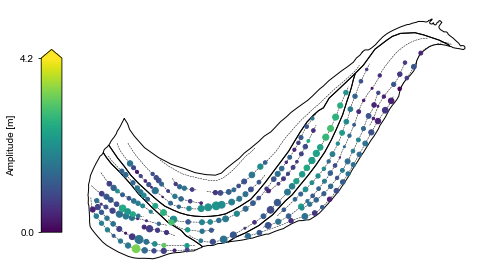

In [47]:
fig = plt.figure(figsize=(10,8))
gs = GridSpec(4,5, figure=fig)

# Main Itx Plot
vmin = 0
vmax = 4.2

## Create Colorbar
ax1 = fig.add_subplot(gs[1:, :4])
divider = make_axes_locatable(ax1)
cax = divider.append_axes("left", size="5%", pad=0.1, aspect=2)

## Plot itx and ridges
itx.plot(ax=ax1, column="ridge_amp", markersize="ridge_width", vmin=vmin, vmax=vmax, legend=True, cax=cax, legend_kwds={"extend":"max"})
ridges.plot(ax=ax1, color="k", ls="--", lw=0.5, zorder=0)
packets.boundary.plot(ax=ax1, color="k", lw=1, zorder=0)

cax.set_yticks([vmin, vmax])
cax.set_ylabel("Amplitude [m]")

cax.yaxis.set_ticks_position('left')
cax.yaxis.set_label_position('left')

ax1.set_axis_off()

# Add box plots for each transect

## Make violin plot

- Unstacking the packet info causes the kernal to crash
    - So we need to achieve the sam effect with loops

/var/folders/bl/pshn9drx0bb1h4fsg0dytv0w0000gn/T/ipykernel_77251/371854471.py:15: PerformanceWarning: indexing past lexsort depth may impact performance.
  vals = itx_packets.loc[p_id, name].values
/var/folders/bl/pshn9drx0bb1h4fsg0dytv0w0000gn/T/ipykernel_77251/371854471.py:15: PerformanceWarning: indexing past lexsort depth may impact performance.
  vals = itx_packets.loc[p_id, name].values
/var/folders/bl/pshn9drx0bb1h4fsg0dytv0w0000gn/T/ipykernel_77251/371854471.py:15: PerformanceWarning: indexing past lexsort depth may impact performance.
  vals = itx_packets.loc[p_id, name].values
/var/folders/bl/pshn9drx0bb1h4fsg0dytv0w0000gn/T/ipykernel_77251/371854471.py:15: PerformanceWarning: indexing past lexsort depth may impact performance.
  vals = itx_packets.loc[p_id, name].values
/var/folders/bl/pshn9drx0bb1h4fsg0dytv0w0000gn/T/ipykernel_77251/371854471.py:15: PerformanceWarning: indexing past lexsort depth may impact performance.
  vals = itx_packets.loc[p_id, name].values
/var/folde

Text(0.5, 0.98, 'Ridge metrics by packet: LBR_025')

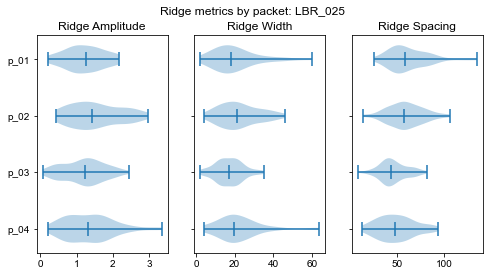

In [48]:
ridge_metrics = violin_data(itx_packets)
sorted_packet_ids = itx_packets.index.get_level_values(0).unique().sort_values(ascending=False).values

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(8, 4))

# Plot 1 - Amps
ax1.violinplot([ridge_metrics["ridge_amp"][i] for i in sorted_packet_ids], vert=False, showmedians=True)

ax1.set_yticks(range(1, 5))
ax1.set_yticklabels(sorted_packet_ids)
ax1.set_title("Ridge Amplitude")

# Plot 2 - Width
ax2.violinplot([ridge_metrics["ridge_width"][i] for i in sorted_packet_ids], vert=False, showmedians=True)

ax2.set_yticks(range(1, 4))
ax2.set_yticklabels([])
ax2.set_title("Ridge Width")

# Plot 1 - Amps
ax3.violinplot([ridge_metrics["pre_mig_dist"][i] for i in sorted_packet_ids], vert=False, showmedians=True)

ax3.set_yticks(range(1, 4))
ax3.set_yticklabels([])
ax3.set_title("Ridge Spacing")
plt.suptitle(f"Ridge metrics by packet: {bend_id}")
# plt.savefig(f"/Users/avan/FLUD/BrazosScrolls/figures/RidgeMetricsWithinPackets_{bend_id}.png", dpi=200)

## Find the directional variaiton within packets

In [49]:
for i, row in packets.iterrows():
    print(i)
    # p_id = row["packet_id"]
    # x,y = packet_points.set_index("packet_id").loc[p_id, "geometry"].coords[0]
    # print(x, y)

p_02
p_03
p_04
p_01


In [77]:
itx

start_distances  transect_position  metric_confidence  \
transect_id ridge_id                                                          
t_009       r_002          185.679231                  4                  4   
            r_003          247.186196                  5                  4   
            r_007          334.035335                  6                  4   
            r_020          134.453913                  2                  3   
            r_021          143.944865                  3                  4   
...                               ...                ...                ...   
t_047       r_012           85.960167                  1                  4   
            r_013            0.000000                  0                  3   
t_048       r_012           90.779112                  1                  4   
            r_013            0.000000                  0                  3   
t_049       r_013            0.000000                  0                  4   

                                              relative_vertex_distances  \
transect_id ridge_id                                                      
t_009       r_002     [0.4251412010392586, 0.5659708704817383, 0.764...   
            r_003     [0.5659708704817383, 0.764825353200405, 0.8918...   
            r_007     [0.764825353200405, 0.8918286694627616, 1.0000...   
            r_020     [0.3078529440844938, 0.32958394119867185, 0.42...   
            r_021     [0.32958394119867185, 0.4251412010392586, 0.56...   
...                                                                 ...   
t_047       r_012         [0.4166174236356562, 0.6066982445541846, 1.0]   
            r_013         [0.0, 0.4166174236356562, 0.6066982445541846]   
t_048       r_012        [0.44520930926787755, 0.6797116866510093, 1.0]   
            r_013        [0.0, 0.44520930926787755, 0.6797116866510093]   
t_049       r_013                        [0.0, 0.6253110072060771, 1.0]   

                       vertex_indices  \
transect_id ridge_id                    
t_009       r_002     [185, 247, 333]   
            r_003     [247, 333, 389]   
            r_007     [333, 389, 436]   
            r_020     [134, 144, 185]   
            r_021     [144, 185, 247]   
...                               ...   
t_047       r_012      [86, 125, 206]   
            r_013        [0, 86, 125]   
t_048       r_012      [91, 139, 204]   
            r_013        [0, 91, 139]   
t_049       r_013       [0, 117, 187]   

                                                             dem_signal  \
transect_id ridge_id                                                      
t_009       r_002     [67.69890594482422, 67.68925476074219, 67.6816...   
            r_003     [66.97003173828125, 66.94657897949219, 66.8770...   
            r_007     [66.9379653930664, 66.9395980834961, 67.164581...   
            r_020     [68.41007232666016, 68.43809509277344, 68.4441...   
            r_021     [68.94662475585938, 68.85785675048828, 68.8740...   
...                                                                 ...   
t_047       r_012     [63.39339828491211, 63.35837173461914, 63.3489...   
            r_013     [nan, nan, nan, nan, nan, nan, nan, nan, nan, ...   
t_048       r_012     [63.420318603515625, 63.39728546142578, 63.380...   
            r_013     [nan, nan, nan, nan, nan, nan, nan, nan, nan, ...   
t_049       r_013     [nan, nan, nan, nan, nan, nan, nan, nan, nan, ...   

                                                   dem_signal_selection  \
transect_id ridge_id                                                      
t_009       r_002     [67.69890594482422, 67.68925476074219, 67.6816...   
            r_003     [66.97003173828125, 66.94657897949219, 66.8770...   
            r_007     [66.9379653930664, 66.9395980834961, 67.164581...   
            r_020     [68.41007232666016, 68.43809509277344, 68.4441...   
            r_021     [68.94662475585938, 68.8578567504882

<AxesSubplot:>

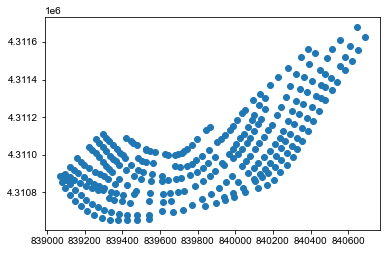

In [86]:
transects.geometry.apply(lambda x: MultiPoint(x.coords[1:])).plot()

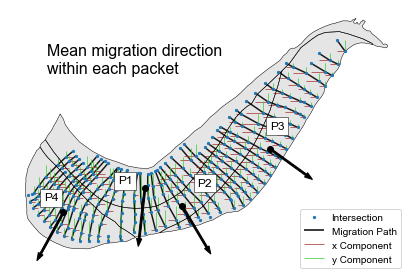

In [130]:
fig, ax = plt.subplots(1,1, figsize=(6,4))

# Plot points and thier component directions
transects.geometry.apply(lambda x: MultiPoint(x.coords[1:])).plot(ax=ax, markersize=5, zorder=3, label="Intersection")
itx_packets.set_geometry("pre_mig_geometry").plot(ax=ax, color="k", zorder=1, label="Migration Path")
itx_packets.set_geometry("x_comp_geometry").plot(ax=ax, lw=1, color="brown", alpha=0.7, label="x Component")
itx_packets.set_geometry("y_comp_geometry").plot(ax=ax, lw=1, color="limegreen", alpha=0.7, label="y Component")

# Plot packets
packets.boundary.plot(ax=ax, lw=0.5, color="k")
packets.plot(ax=ax, color="grey", alpha=0.2)
packet_points.plot(ax=ax, color="k", zorder=3)

# Plot arrows showing the mean component direction
for i, row in packets.iterrows():
    x,y = packet_points.loc[i, "geometry"].coords[0]
    plt.arrow(x, y, -row["x_comp_distance"]*5, -row["y_comp_distance"]*5, width=9, color="k", zorder=3)

# Plot packet labels
label_offsets = {"p_01":(-140, 20), "p_02":(80, 100), "p_03":(0, 100), "p_04":(-100, 60)}
for idx, row in packet_points.iterrows():
    x, y = row["geometry"].coords[0]
    x_text = x + label_offsets[idx][0]
    y_text = y + label_offsets[idx][1]
    anno = plt.annotate(text=f"P{idx[-1]}", xy=(x, y), xytext=(x_text,y_text),
                 horizontalalignment='left', size=12)
    anno.set_bbox(dict(facecolor='white', edgecolor='k', lw=0.5))

# ax.set_title(f"Mean migration direction within each packet: {bend_id}", size=14)

title_coords = (839355, 4311246)
ax.text(0.1, 0.75,"Mean migration direction\nwithin each packet", transform=ax.transAxes, size=16)
ax.legend(loc="lower right")
ax.set_axis_off()
plt.tight_layout()
plt.savefig(f"MigrationDirectionWithinPackets_{bend_id}.png", dpi=200)

## LBR_029

In [81]:
bend_id = "LBR_029"
dem = rasterio.open(RASTER_PATHS[bend_id]["dem"])
bin_raster = rasterio.open(RASTER_PATHS[bend_id]["bin"])

bend_ds = BendDataset(bend_id)
transects = bend_ds.get_transects(proj=True)
ridges = bend_ds.get_ridges(proj=True)
packets = bend_ds.get_packets(proj=True)
packets["centroid"] = packets.centroid


In [82]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore", ShapelyDeprecationWarning)
    rich_transects, itx = calculate_ridge_metrics(transects, bin_raster, dem, ridges)

# Additional processes that need to be integrated upstream
itx = itx.droplevel(0)
itx = itx[itx.metric_confidence>1]
itx["pre_mig_geometry"] = itx["substring_geometry"].apply(lambda x: LineString(x.coords[1:]))
itx_packets = join_packet_info(itx, packets)
itx_packets = calc_component_geometries(itx_packets)
packets = calc_mean_comp_distances(packets, itx_packets)


Started BDE
Started TDE for t_003
Started TDE for t_004
Started TDE for t_005
Started TDE for t_006
Started RDE
Started TDE for t_007
Started RDE
Started TDE for t_008
Started RDE
Started TDE for t_009
Started RDE
Started RDE
Started TDE for t_010
Started RDE
Started RDE
Started RDE
Started RDE
Started TDE for t_011
Started RDE
Started RDE
Started RDE
Started RDE
Started RDE
Started TDE for t_012
Started RDE
Started RDE
Started RDE
Started RDE
Started RDE
Started RDE
Started TDE for t_013
Started RDE
Started RDE
Started RDE
Started RDE
Started RDE
Started RDE
Started TDE for t_014
Started RDE
Started RDE
Started RDE
Started RDE
Started RDE
Started RDE
Started RDE
Started TDE for t_015
Started RDE
Started RDE
Started RDE
Started RDE
Started RDE
Started RDE
Started RDE
Started TDE for t_016
Started RDE
Started RDE
Started RDE
Started RDE
Started RDE
Started RDE
Started RDE
Started TDE for t_017
Started RDE
Started RDE
Started RDE
Started RDE
Started RDE
Started RDE
Started RDE
Started RD

/Users/avan/opt/miniconda3/envs/scroll/lib/python3.8/site-packages/pandas/core/dtypes/cast.py:122: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)
/Users/avan/opt/miniconda3/envs/scroll/lib/python3.8/site-packages/pandas/core/dtypes/cast.py:122: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)


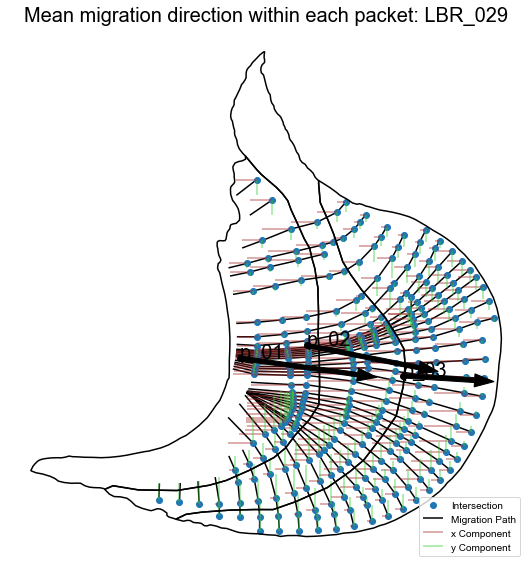

In [83]:
fig, ax = plt.subplots(1,1, figsize=(10,8))

# Plot points and thier component directions
itx_packets.plot(ax=ax, zorder=2, label="Intersection")
itx_packets.set_geometry("pre_mig_geometry").plot(ax=ax, color="k", zorder=1, label="Migration Path")
itx_packets.set_geometry("x_comp_geometry").plot(ax=ax, color="brown", alpha=0.5, label="x Component")
itx_packets.set_geometry("y_comp_geometry").plot(ax=ax, color="limegreen", alpha=0.5, label="y Component")

# Plot packets
packets.boundary.plot(ax=ax, color="k")
packets.set_geometry("centroid").plot(ax=ax, color="k", zorder=3)

# Plot arrows showing the mean component direction
for i, row in packets.iterrows():
    x, y = row["centroid"].coords[0]
    plt.arrow(x, y, -row["x_comp_distance"]*5, -row["y_comp_distance"]*5, width=9, color="k", zorder=3)

# Plot packet labels
for idx, row in packets.iterrows():
    plt.annotate(text=idx, xy=row["centroid"].coords[0],
                 horizontalalignment='left', size=20)

ax.set_title(f"Mean migration direction within each packet: {bend_id}", size=20)
ax.legend(loc="lower right")
ax.set_axis_off()
plt.tight_layout()
plt.savefig(f"MigrationDirectionWithinPackets_{bend_id}.png", dpi=200)

### Violin plots

/var/folders/bl/pshn9drx0bb1h4fsg0dytv0w0000gn/T/ipykernel_3798/371854471.py:15: PerformanceWarning: indexing past lexsort depth may impact performance.
  vals = itx_packets.loc[p_id, name].values
/var/folders/bl/pshn9drx0bb1h4fsg0dytv0w0000gn/T/ipykernel_3798/371854471.py:15: PerformanceWarning: indexing past lexsort depth may impact performance.
  vals = itx_packets.loc[p_id, name].values
/var/folders/bl/pshn9drx0bb1h4fsg0dytv0w0000gn/T/ipykernel_3798/371854471.py:15: PerformanceWarning: indexing past lexsort depth may impact performance.
  vals = itx_packets.loc[p_id, name].values
/var/folders/bl/pshn9drx0bb1h4fsg0dytv0w0000gn/T/ipykernel_3798/371854471.py:15: PerformanceWarning: indexing past lexsort depth may impact performance.
  vals = itx_packets.loc[p_id, name].values
/var/folders/bl/pshn9drx0bb1h4fsg0dytv0w0000gn/T/ipykernel_3798/371854471.py:15: PerformanceWarning: indexing past lexsort depth may impact performance.
  vals = itx_packets.loc[p_id, name].values
/var/folders/bl

Text(0.5, 0.98, 'Ridge metrics by packet: LBR_029')

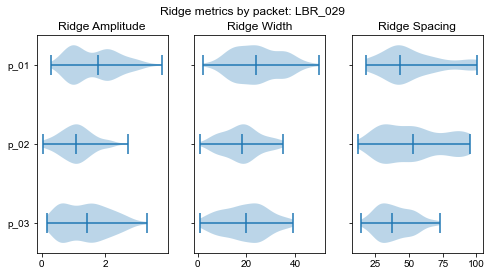

In [84]:
ridge_metrics = violin_data(itx_packets)
sorted_packet_ids = itx_packets.index.get_level_values(0).unique().sort_values(ascending=False).values

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(8, 4))

# Plot 1 - Amps
ax1.violinplot([ridge_metrics["ridge_amp"][i] for i in sorted_packet_ids], vert=False, showmedians=True)

ax1.set_yticks(range(1, 4))
ax1.set_yticklabels(sorted_packet_ids)
ax1.set_title("Ridge Amplitude")

# Plot 2 - Width
ax2.violinplot([ridge_metrics["ridge_width"][i] for i in sorted_packet_ids], vert=False, showmedians=True)

ax2.set_yticks(range(1, 4))
ax2.set_yticklabels([])
ax2.set_title("Ridge Width")

# Plot 1 - Amps
ax3.violinplot([ridge_metrics["pre_mig_dist"][i] for i in sorted_packet_ids], vert=False, showmedians=True)

ax3.set_yticks(range(1, 4))
ax3.set_yticklabels([])
ax3.set_title("Ridge Spacing")
plt.suptitle(f"Ridge metrics by packet: {bend_id}")
# plt.savefig(f"/Users/avan/FLUD/BrazosScrolls/figures/RidgeMetricsWithinPackets_{bend_id}.png", dpi=200)

## LBR_043

In [85]:
bend_id = "LBR_043"
dem = rasterio.open(RASTER_PATHS[bend_id]["dem"])
bin_raster = rasterio.open(RASTER_PATHS[bend_id]["bin"])

bend_ds = BendDataset(bend_id)
transects = bend_ds.get_transects(proj=True)
ridges = bend_ds.get_ridges(proj=True)
packets = bend_ds.get_packets(proj=True)
packets["centroid"] = packets.centroid


In [86]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore", ShapelyDeprecationWarning)
    rich_transects, itx = calculate_ridge_metrics(transects, bin_raster, dem, ridges)

# Additional processes that need to be integrated upstream
itx = itx.droplevel(0)
itx = itx[itx.metric_confidence>1]
itx["pre_mig_geometry"] = itx["substring_geometry"].apply(lambda x: LineString(x.coords[1:]))
itx_packets = join_packet_info(itx, packets)
itx_packets = calc_component_geometries(itx_packets)
packets = calc_mean_comp_distances(packets, itx_packets)

Started BDE
Started TDE for t_017
Started RDE
Started RDE
Started RDE
Started RDE
Started RDE
Started RDE
Started RDE
Started RDE
Started RDE
Started RDE
Started TDE for t_018
Started RDE
Started RDE
Started RDE
Started RDE
Started RDE
Started RDE
Started RDE
Started RDE
Started RDE
Started RDE
Started RDE
Started TDE for t_019
Started RDE
Started RDE
Started RDE
Started RDE
Started RDE
Started RDE
Started RDE
Started RDE
Started RDE
Started RDE
Started RDE
Started TDE for t_020
Started RDE
Started RDE
Started RDE
Started RDE
Started RDE
Started RDE
Started RDE
Started RDE
Started RDE
Started RDE
Started RDE
Started TDE for t_021
Started RDE
Started RDE
Started RDE
Started RDE
Started RDE
Started RDE
Started RDE
Started RDE
Started RDE
Started RDE
Started RDE
Started TDE for t_022
Started RDE
Started TDE for t_023
Started RDE
Started RDE
Started RDE
Started RDE
Started RDE
Started RDE
Started RDE
Started RDE
Started RDE
Started RDE
Started RDE
Started RDE
Started TDE for t_024
Started 

/Users/avan/opt/miniconda3/envs/scroll/lib/python3.8/site-packages/pandas/core/dtypes/cast.py:122: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)
/Users/avan/opt/miniconda3/envs/scroll/lib/python3.8/site-packages/pandas/core/dtypes/cast.py:122: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)


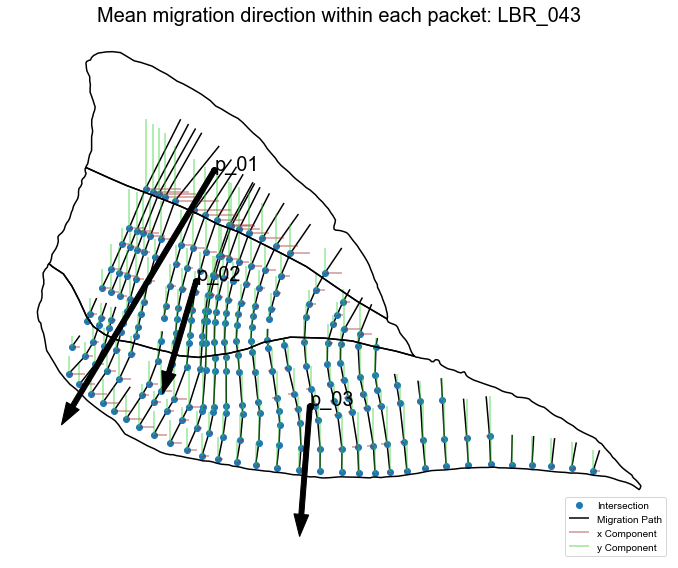

In [87]:
fig, ax = plt.subplots(1,1, figsize=(10,8))

# Plot points and thier component directions
itx_packets.plot(ax=ax, zorder=2, label="Intersection")
itx_packets.set_geometry("pre_mig_geometry").plot(ax=ax, color="k", zorder=1, label="Migration Path")
itx_packets.set_geometry("x_comp_geometry").plot(ax=ax, color="brown", alpha=0.5, label="x Component")
itx_packets.set_geometry("y_comp_geometry").plot(ax=ax, color="limegreen", alpha=0.5, label="y Component")

# Plot packets
packets.boundary.plot(ax=ax, color="k")
packets.set_geometry("centroid").plot(ax=ax, color="k", zorder=3)

# Plot arrows showing the mean component direction
for i, row in packets.iterrows():
    x, y = row["centroid"].coords[0]
    plt.arrow(x, y, -row["x_comp_distance"]*5, -row["y_comp_distance"]*5, width=9, color="k", zorder=3)

# Plot packet labels
for idx, row in packets.iterrows():
    plt.annotate(text=idx, xy=row["centroid"].coords[0],
                 horizontalalignment='left', size=20)

ax.set_title(f"Mean migration direction within each packet: {bend_id}", size=20)
ax.legend(loc="lower right")
ax.set_axis_off()
plt.tight_layout()
plt.savefig(f"MigrationDirectionWithinPackets_{bend_id}.png", dpi=200)

/var/folders/bl/pshn9drx0bb1h4fsg0dytv0w0000gn/T/ipykernel_3798/371854471.py:15: PerformanceWarning: indexing past lexsort depth may impact performance.
  vals = itx_packets.loc[p_id, name].values
/var/folders/bl/pshn9drx0bb1h4fsg0dytv0w0000gn/T/ipykernel_3798/371854471.py:15: PerformanceWarning: indexing past lexsort depth may impact performance.
  vals = itx_packets.loc[p_id, name].values
/var/folders/bl/pshn9drx0bb1h4fsg0dytv0w0000gn/T/ipykernel_3798/371854471.py:15: PerformanceWarning: indexing past lexsort depth may impact performance.
  vals = itx_packets.loc[p_id, name].values
/var/folders/bl/pshn9drx0bb1h4fsg0dytv0w0000gn/T/ipykernel_3798/371854471.py:15: PerformanceWarning: indexing past lexsort depth may impact performance.
  vals = itx_packets.loc[p_id, name].values
/var/folders/bl/pshn9drx0bb1h4fsg0dytv0w0000gn/T/ipykernel_3798/371854471.py:15: PerformanceWarning: indexing past lexsort depth may impact performance.
  vals = itx_packets.loc[p_id, name].values
/var/folders/bl

Text(0.5, 0.98, 'Ridge metrics by packet: LBR_043')

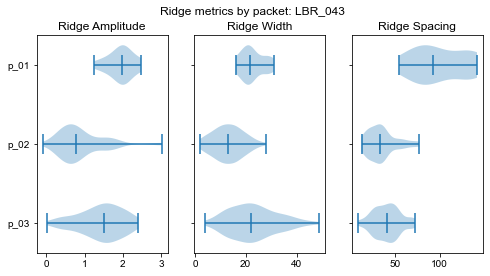

In [88]:
ridge_metrics = violin_data(itx_packets)
sorted_packet_ids = itx_packets.index.get_level_values(0).unique().sort_values(ascending=False).values

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(8, 4))

# Plot 1 - Amps
ax1.violinplot([ridge_metrics["ridge_amp"][i] for i in sorted_packet_ids], vert=False, showmedians=True)

ax1.set_yticks(range(1, 4))
ax1.set_yticklabels(sorted_packet_ids)
ax1.set_title("Ridge Amplitude")

# Plot 2 - Width
ax2.violinplot([ridge_metrics["ridge_width"][i] for i in sorted_packet_ids], vert=False, showmedians=True)

ax2.set_yticks(range(1, 4))
ax2.set_yticklabels([])
ax2.set_title("Ridge Width")

# Plot 1 - Amps
ax3.violinplot([ridge_metrics["pre_mig_dist"][i] for i in sorted_packet_ids], vert=False, showmedians=True)

ax3.set_yticks(range(1, 4))
ax3.set_yticklabels([])
ax3.set_title("Ridge Spacing")
plt.suptitle(f"Ridge metrics by packet: {bend_id}")
# plt.savefig(f"/Users/avan/FLUD/BrazosScrolls/figures/RidgeMetricsWithinPackets_{bend_id}.png", dpi=200)

## LBR_077

In [89]:
bend_id = "LBR_077"
dem = rasterio.open(RASTER_PATHS[bend_id]["dem"])
bin_raster = rasterio.open(RASTER_PATHS[bend_id]["bin"])

bend_ds = BendDataset(bend_id)
transects = bend_ds.get_transects(proj=True)
ridges = bend_ds.get_ridges(proj=True)
packets = bend_ds.get_packets(proj=True)
packets["centroid"] = packets.centroid


In [90]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore", ShapelyDeprecationWarning)
    rich_transects, itx = calculate_ridge_metrics(transects, bin_raster, dem, ridges)

# Additional processes that need to be integrated upstream
itx = itx.droplevel(0)
itx = itx[itx.metric_confidence>1]
itx["pre_mig_geometry"] = itx["substring_geometry"].apply(lambda x: LineString(x.coords[1:]))
itx_packets = join_packet_info(itx, packets)
itx_packets = calc_component_geometries(itx_packets)
packets = calc_mean_comp_distances(packets, itx_packets)

Started BDE
Started TDE for t_003
Started RDE
Started RDE
Started TDE for t_005
Started RDE
Started RDE
Started RDE
Started RDE
Started RDE
Started RDE
Started RDE
Started RDE
Started TDE for t_006
Started RDE
Started RDE
Started RDE
Started RDE
Started RDE
Started RDE
Started RDE
Started RDE
Started RDE
Started TDE for t_007
Started RDE
Started RDE
Started RDE
Started RDE
Started RDE
Started RDE
Started RDE
Started RDE
Started RDE
Started RDE
Started RDE
Started TDE for t_008
Started RDE
Started RDE
Started RDE
Started RDE
Started RDE
Started RDE
Started RDE
Started RDE
Started RDE
Started RDE
Started RDE
Started TDE for t_009
Started RDE
Started RDE
Started RDE
Started RDE
Started RDE
Started RDE
Started RDE
Started RDE
Started RDE
Started RDE
Started RDE
Started TDE for t_010
Started RDE
Started RDE
Started RDE
Started RDE
Started RDE
Started RDE
Started RDE
Started RDE
Started RDE
Started RDE
Started RDE
Started TDE for t_011
Started RDE
Started RDE
Started RDE
Started RDE
Started 

/Users/avan/FLUD/scrollstats/scrollstats/ridge_metrics/ridgeAmplitudes.py:28: RuntimeWarning: All-NaN slice encountered
  dem_mins = [np.nanmin(dem_sig[labels==i]) for i in np.arange(numfeats)+1]
/Users/avan/FLUD/scrollstats/scrollstats/ridge_metrics/ridgeAmplitudes.py:28: RuntimeWarning: All-NaN slice encountered
  dem_mins = [np.nanmin(dem_sig[labels==i]) for i in np.arange(numfeats)+1]


Started RDE
Started RDE
Started RDE
Started RDE
Started RDE
Started RDE
Started RDE
Started RDE
Started RDE
Started RDE
Started RDE
Started TDE for t_045
Started RDE
Started RDE
Started RDE
Started RDE
Started RDE
Started RDE
Started RDE
Started RDE
Started TDE for t_046
Started RDE
Started RDE
Started RDE
Started RDE
Started RDE
Started RDE
Started TDE for t_047
Started TDE for t_048
Started RDE
Started TDE for t_049
Started RDE


/Users/avan/opt/miniconda3/envs/scroll/lib/python3.8/site-packages/pandas/core/dtypes/cast.py:122: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)
/Users/avan/opt/miniconda3/envs/scroll/lib/python3.8/site-packages/pandas/core/dtypes/cast.py:122: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)


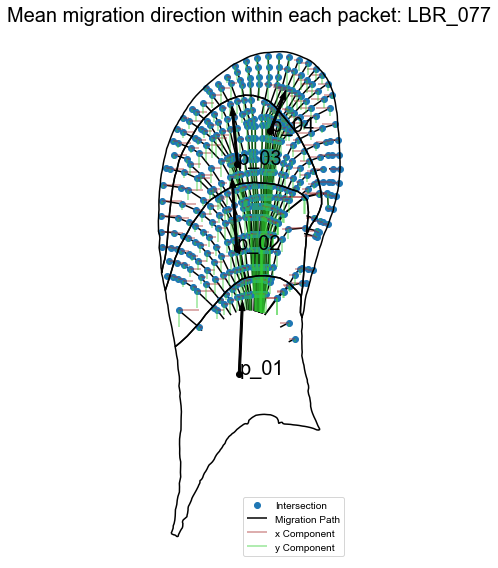

In [91]:
fig, ax = plt.subplots(1,1, figsize=(10,8))

# Plot points and thier component directions
itx_packets.plot(ax=ax, zorder=2, label="Intersection")
itx_packets.set_geometry("pre_mig_geometry").plot(ax=ax, color="k", zorder=1, label="Migration Path")
itx_packets.set_geometry("x_comp_geometry").plot(ax=ax, color="brown", alpha=0.5, label="x Component")
itx_packets.set_geometry("y_comp_geometry").plot(ax=ax, color="limegreen", alpha=0.5, label="y Component")

# Plot packets
packets.boundary.plot(ax=ax, color="k")
packets.set_geometry("centroid").plot(ax=ax, color="k", zorder=3)

# Plot arrows showing the mean component direction
for i, row in packets.iterrows():
    x, y = row["centroid"].coords[0]
    plt.arrow(x, y, -row["x_comp_distance"]*5, -row["y_comp_distance"]*5, width=9, color="k", zorder=3)

# Plot packet labels
for idx, row in packets.iterrows():
    plt.annotate(text=idx, xy=row["centroid"].coords[0],
                 horizontalalignment='left', size=20)

ax.set_title(f"Mean migration direction within each packet: {bend_id}", size=20)
ax.legend(loc="lower right")
ax.set_axis_off()
plt.tight_layout()
plt.savefig(f"MigrationDirectionWithinPackets_{bend_id}.png", dpi=200)

/var/folders/bl/pshn9drx0bb1h4fsg0dytv0w0000gn/T/ipykernel_3798/371854471.py:15: PerformanceWarning: indexing past lexsort depth may impact performance.
  vals = itx_packets.loc[p_id, name].values
/var/folders/bl/pshn9drx0bb1h4fsg0dytv0w0000gn/T/ipykernel_3798/371854471.py:15: PerformanceWarning: indexing past lexsort depth may impact performance.
  vals = itx_packets.loc[p_id, name].values
/var/folders/bl/pshn9drx0bb1h4fsg0dytv0w0000gn/T/ipykernel_3798/371854471.py:15: PerformanceWarning: indexing past lexsort depth may impact performance.
  vals = itx_packets.loc[p_id, name].values
/var/folders/bl/pshn9drx0bb1h4fsg0dytv0w0000gn/T/ipykernel_3798/371854471.py:15: PerformanceWarning: indexing past lexsort depth may impact performance.
  vals = itx_packets.loc[p_id, name].values
/var/folders/bl/pshn9drx0bb1h4fsg0dytv0w0000gn/T/ipykernel_3798/371854471.py:15: PerformanceWarning: indexing past lexsort depth may impact performance.
  vals = itx_packets.loc[p_id, name].values
/var/folders/bl

Text(0.5, 0.98, 'Ridge metrics by packet: LBR_077')

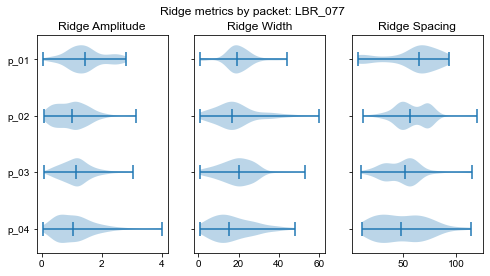

In [92]:
ridge_metrics = violin_data(itx_packets)
sorted_packet_ids = itx_packets.index.get_level_values(0).unique().sort_values(ascending=False).values

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(8, 4))

# Plot 1 - Amps
ax1.violinplot([ridge_metrics["ridge_amp"][i] for i in sorted_packet_ids], vert=False, showmedians=True)

ax1.set_yticks(range(1, 5))
ax1.set_yticklabels(sorted_packet_ids)
ax1.set_title("Ridge Amplitude")

# Plot 2 - Width
ax2.violinplot([ridge_metrics["ridge_width"][i] for i in sorted_packet_ids], vert=False, showmedians=True)

ax2.set_yticks(range(1, 5))
ax2.set_yticklabels([])
ax2.set_title("Ridge Width")

# Plot 1 - Amps
ax3.violinplot([ridge_metrics["pre_mig_dist"][i] for i in sorted_packet_ids], vert=False, showmedians=True)

ax3.set_yticks(range(1, 5))
ax3.set_yticklabels([])
ax3.set_title("Ridge Spacing")
plt.suptitle(f"Ridge metrics by packet: {bend_id}")
# plt.savefig(f"/Users/avan/FLUD/BrazosScrolls/figures/RidgeMetricsWithinPackets_{bend_id}.png", dpi=200)

In [93]:
itx_packets["ridge_amp"].sort_values()

packet_id  transect_id  ridge_id
p_01       t_045        r_026       0.023096
p_04       t_040        r_006       0.041703
           t_044        r_005       0.042343
p_03       t_005        r_013       0.072727
p_02       t_012        r_018       0.088139
                                      ...   
           t_038        r_016       3.020056
p_03       t_016        r_008       3.045248
p_02       t_037        r_016       3.084377
           t_045        r_017       3.152122
p_04       t_041        r_005       4.000021
Name: ridge_amp, Length: 614, dtype: float64